# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [1]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [2]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 192 # 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point" # "3-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 20 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "plain"
weighted = False #True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.2

# Mock cycle/two-level cycle nu value list.
nu_values = np.arange(1, 12)

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.49071886103381135


## Level 0->1 Coarsening

In [3]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)

# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

# Save null-space vectors so we dan orthogonalize error vectors to them.
num_eigenvectors = 10
z, lam = hm.analysis.ideal.ideal_tv(level.a, num_eigenvectors)
ind = (np.abs(lam[:num_eigenvectors]) < 1e-6)
z = z[:, ind]
z = hm.linalg.gram_schmidt(z)

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.299e+00                    4.471e-01    2.901
INFO     1     7.238e-01 (0.558) [0.558]    3.459e-01    2.094 (0.721)
INFO     2     4.215e-01 (0.583) [0.570]    2.975e-01    1.421 (0.678)
INFO     3     2.664e-01 (0.633) [0.590]    2.727e-01    0.982 (0.691)
INFO     4     1.841e-01 (0.692) [0.614]    2.580e-01    0.717 (0.731)
INFO     5     1.388e-01 (0.754) [0.640]    2.480e-01    0.563 (0.785)
INFO     6     1.126e-01 (0.811) [0.666]    2.406e-01    0.471 (0.837)
INFO     7     9.614e-02 (0.853) [0.690]    2.346e-01    0.412 (0.875)
INFO     8     8.494e-02 (0.883) [0.712]    2.296e-01    0.372 (0.903)
INFO     9     7.679e-02 (0.904) [0.731]    2.253e-01    0.343 (0.921)
INFO     10    7.056e-02 (0.919) [0.748]    2.215e-01    0.320 (0.935)
INFO     11    6.560e-02 (0.930) [0.763]    2.181e-01    0.302 (0.944)
INFO     12    6.154e-02 (0.938) [0.776]    2.150e-01    0.288 (0.952)
INFO 

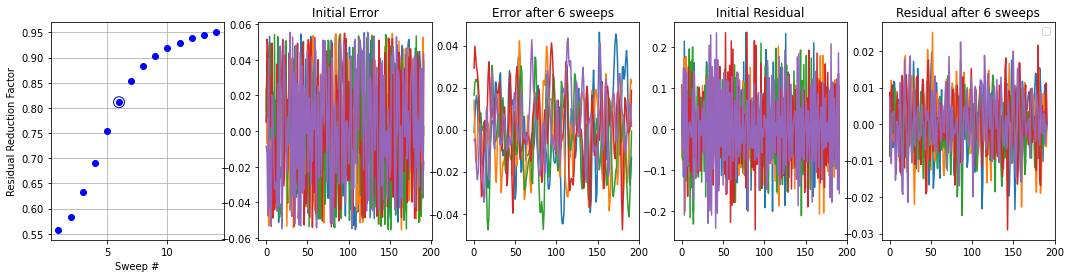

In [4]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

### Coarsening: Fixed (4/2)
Measure local two-level rates on a domain of size $m=6$ aggregates.

In [24]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
aggregate_size = 4
num_components = 2
nu_coarsest = -1
m = 8

coarsening_types = [
    ("P^T A P caliber 2", 2, "pt"),
    ("P^T A P caliber 3", 3, "pt"),
    ("P^T A P caliber 4", 4, "pt"),
    ("Q A P caliber 4"  , 4, "q"),
    ("R A P caliber 4"  , 4, "r"),
]

all_conv, r, p, q = helmholtz.analysis.stats.compare_coarsening(
    level, coarsening_types, nu, 
                       domain_size,
                       aggregate_size, num_components,
                       ideal_tv=ideal_tv,
                       num_examples=num_examples,
                       nu_values=nu_values,
                       nu_coarsest=nu_coarsest,
                       interpolation_method=interpolation_method,
                       fit_scheme=fit_scheme,
                       weighted=weighted,
                       neighborhood=neighborhood,
                       repetitive=repetitive,
                       m=m)

styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

p = p[4]

INFO     Generating 4 TVs with 20 sweeps
INFO     RER 0.193


,Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,0.5165,0.1416,0.1272,0.1116,0.0812,0.0573,0.0681,0.0570,0.0630,0.0571,0.0527
P^T A P caliber 2,1.1429,0.0000,0.4667,0.3355,0.4377,0.4191,0.4172,0.4049,0.3829,0.3928,0.3446,0.3623,0.3336
P^T A P caliber 3,1.2987,0.0000,0.5145,0.2841,0.2330,0.3117,0.2749,0.2571,0.2576,0.2537,0.2431,0.2388,0.2202
P^T A P caliber 4,1.7662,0.0000,0.4091,0.2235,0.1470,0.1132,0.1128,0.0876,0.0605,0.0484,0.0439,0.0395,0.0370
Q A P caliber 4,1.1429,0.0048,0.8643,0.3576,0.1939,0.1149,0.1150,0.0796,0.0559,0.0491,0.0555,0.0548,0.0502
R A P caliber 4,1.1429,0.0072,0.9627,0.2625,0.1824,0.1313,0.1160,0.0653,0.0641,0.0496,0.0539,0.0521,0.0477


In [25]:
# Using GMRES as as a coarse-level solver seems to be a robust choice vs. m (domain size).
m = 4
nu_coarsest = -1
ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, q, aggregate_size, num_components, m=m)
two_level_conv = hm.repetitive.locality.two_level_conv_factor(
    ml, 3, nu_coarsest=nu_coarsest, print_frequency=1, debug=False, num_sweeps=8)

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      8.235e+00           2.071           3.977
INFO     1      1.513e+00  (0.184)  1.360  (0.657)  1.113
INFO     2      3.486e-01  (0.230)  1.946  (1.431)  0.179
INFO     3      8.255e-02  (0.237)  2.663  (1.368)  0.031
INFO     4      2.003e-02  (0.243)  2.462  (0.924)  0.008
INFO     5      3.455e-03  (0.173)  2.463  (1.000)  0.001
INFO     6      5.123e-04  (0.148)  3.089  (1.254)  0.000
INFO     7      7.338e-05  (0.143)  2.830  (0.916)  0.000
INFO     8      1.098e-05  (0.150)  2.560  (0.904)  0.000


In [26]:
# full domain 2-level convergence.
nu_coarsest = 100
ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, q, aggregate_size, num_components)
two_level_conv = hm.repetitive.locality.two_level_conv_factor(
    ml, 8, nu_coarsest=nu_coarsest, print_frequency=1, debug=False)

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.646e+01           2.394           11.052
INFO     1      1.463e+00  (0.055)  2.067  (0.864)  0.708
INFO     2      6.656e-02  (0.045)  0.268  (0.130)  0.248
INFO     3      6.937e-03  (0.104)  0.039  (0.146)  0.177
INFO     4      2.362e-03  (0.340)  0.015  (0.375)  0.161
INFO     5      1.018e-03  (0.431)  0.006  (0.440)  0.157
INFO     6      4.409e-04  (0.433)  0.003  (0.435)  0.157
INFO     7      1.910e-04  (0.433)  0.001  (0.434)  0.157
INFO     8      8.274e-05  (0.433)  0.001  (0.433)  0.157
INFO     9      3.584e-05  (0.433)  0.000  (0.433)  0.157
INFO     10     1.552e-05  (0.433)  0.000  (0.433)  0.157
INFO     11     6.723e-06  (0.433)  0.000  (0.433)  0.157
INFO     12     2.912e-06  (0.433)  0.000  (0.433)  0.157
INFO     13     1.261e-06  (0.433)  0.000  (0.433)  0.157
INFO     14     5.460e-07  (0.433)  0.000  (0.433)  0.157
INFO     15     2.364e-07  (0.433)  0.000  (0.433)  0.157
INFO     16 

## Symmetrizing $R A P$ into $Q A P$

### Slowest Component, RER reduction
All measurements (RER, plot of errors) are performed after removing the null components after each cycle. Cycles are $(0, \nu)$, so the error is measured after relaxations.

#### Two-level Cycle with exact coarse level solve

Restriction r
INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.749e+01           2.453           11.204
INFO     1      4.677e+00  (0.170)  0.537  (0.219)  8.703
INFO     2      8.883e-01  (0.190)  1.036  (1.928)  0.857
INFO     3      5.920e-01  (0.666)  2.395  (2.312)  0.247
INFO     4      4.377e-01  (0.739)  2.537  (1.059)  0.173
INFO     5      3.313e-01  (0.757)  2.763  (1.089)  0.120
INFO     6      2.484e-01  (0.750)  2.697  (0.976)  0.092
INFO     7      1.865e-01  (0.751)  2.623  (0.973)  0.071
INFO     8      1.410e-01  (0.756)  2.842  (1.083)  0.050
INFO     9      1.050e-01  (0.745)  2.520  (0.887)  0.042
INFO     10     7.993e-02  (0.761)  2.951  (1.171)  0.027
INFO     11     5.927e-02  (0.742)  2.475  (0.839)  0.024
INFO     12     4.522e-02  (0.763)  2.971  (1.200)  0.015
INFO     13     3.352e-02  (0.741)  2.495  (0.840)  0.013
INFO     14     2.552e-02  (0.761)  2.891  (1.159)  0.009
INFO     15     1.900e-02  (0.745)  2.577  (0.891)  0.00

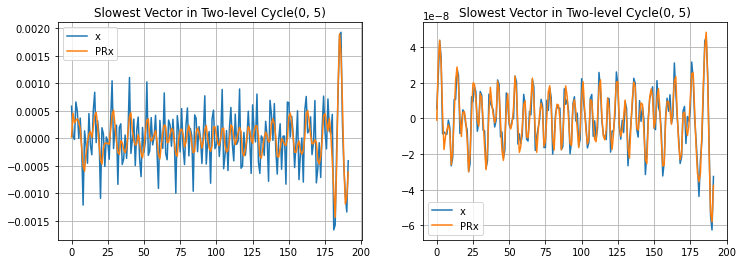

In [27]:
helmholtz.analysis.stats.run_r_vs_q(level, z, r, p, q, aggregate_size, num_components, 5, -1)

#### Two-level Cycle with many relaxations at coarse level

Restriction r
INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.749e+01           2.453           11.204
INFO     1      4.576e+00  (0.167)  0.526  (0.214)  8.699
INFO     2      4.327e-01  (0.095)  0.540  (1.027)  0.801
INFO     3      6.344e-02  (0.147)  0.489  (0.906)  0.130
INFO     4      1.035e-02  (0.163)  0.525  (1.073)  0.020
INFO     5      1.777e-03  (0.172)  0.522  (0.995)  0.003
INFO     6      3.351e-04  (0.189)  0.535  (1.025)  0.001
INFO     7      6.279e-05  (0.187)  0.537  (1.003)  0.000
INFO     8      1.200e-05  (0.191)  0.535  (0.997)  0.000
INFO     9      2.306e-06  (0.192)  0.537  (1.003)  0.000
INFO     10     4.538e-07  (0.197)  0.544  (1.012)  0.000
INFO     11     8.938e-08  (0.197)  0.541  (0.995)  0.000
INFO     12     1.755e-08  (0.196)  0.538  (0.995)  0.000
INFO     13     3.451e-09  (0.197)  0.537  (0.997)  0.000
INFO     14     6.723e-10  (0.195)  0.532  (0.991)  0.000
INFO     15     1.287e-10  (0.191)  0.523  (0.984)  0.00

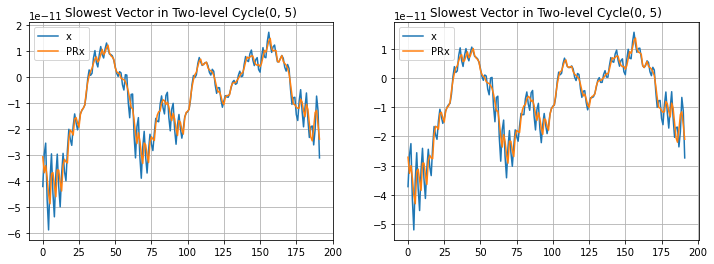

In [28]:
helmholtz.analysis.stats.run_r_vs_q(level, z, r, p, q, aggregate_size, num_components, 5, 0)

#### Two-level Relaxation Mini-Cycle

Restriction r
INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      2.749e+01           2.453           11.204
INFO     1      4.639e+00  (0.169)  0.708  (0.289)  6.552
INFO     2      5.411e-01  (0.117)  0.233  (0.329)  2.324
INFO     3      1.610e-01  (0.297)  0.097  (0.417)  1.659
INFO     4      1.059e-01  (0.658)  0.077  (0.793)  1.376
INFO     5      7.953e-02  (0.751)  0.066  (0.860)  1.202
INFO     6      6.341e-02  (0.797)  0.059  (0.885)  1.082
INFO     7      5.298e-02  (0.836)  0.053  (0.910)  0.994
INFO     8      4.593e-02  (0.867)  0.050  (0.932)  0.925
INFO     9      4.094e-02  (0.891)  0.047  (0.950)  0.868
INFO     10     3.723e-02  (0.909)  0.045  (0.963)  0.819
INFO     11     3.432e-02  (0.922)  0.044  (0.973)  0.776
INFO     12     3.194e-02  (0.931)  0.043  (0.980)  0.737
INFO     13     2.994e-02  (0.937)  0.043  (0.985)  0.701
INFO     14     2.819e-02  (0.942)  0.042  (0.988)  0.668
INFO     15     2.664e-02  (0.945)  0.042  (0.991)  0.63

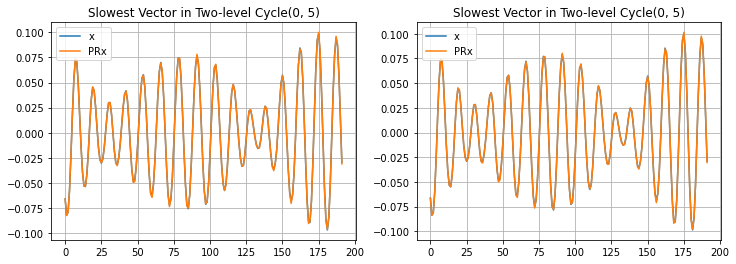

In [29]:
helmholtz.analysis.stats.run_r_vs_q(level, z, r, p, q, aggregate_size, num_components, 5, 5)

#### Level 1 Relaxation Shrinkage

#### $P^T A P$

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     4.048e-01                    4.469e-01    0.908
INFO     1     1.363e-01 (0.340) [0.340]    2.975e-01    0.460 (0.512)
INFO     2     8.830e-02 (0.654) [0.468]    2.538e-01    0.352 (0.769)
INFO     3     6.421e-02 (0.727) [0.542]    2.312e-01    0.280 (0.798)
INFO     4     5.121e-02 (0.794) [0.597]    2.155e-01    0.238 (0.853)
INFO     5     4.320e-02 (0.841) [0.640]    2.033e-01    0.212 (0.891)
INFO     6     3.748e-02 (0.865) [0.673]    1.936e-01    0.193 (0.909)
INFO     7     3.319e-02 (0.884) [0.700]    1.855e-01    0.178 (0.922)
INFO     8     2.985e-02 (0.898) [0.722]    1.786e-01    0.167 (0.932)
INFO     9     2.717e-02 (0.909) [0.741]    1.727e-01    0.157 (0.940)
INFO     10    2.497e-02 (0.919) [0.757]    1.676e-01    0.149 (0.947)
INFO     11    2.312e-02 (0.926) [0.771]    1.631e-01    0.142 (0.952)
INFO     12    2.155e-02 (0.932) [0.784]    1.591e-01    0.136 (0.956)
INFO 

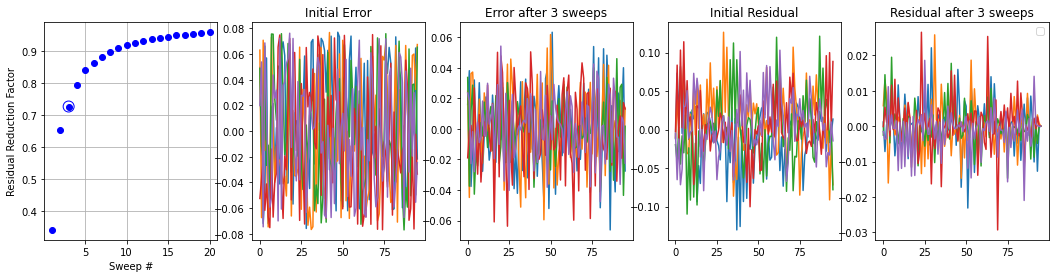

In [30]:
m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, p.T, aggregate_size, num_components)
m1 = m0.sub_hierarchy(1)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

#### $Q A P$

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.822e-01                    4.470e-01    0.632
INFO     1     1.028e-01 (0.365) [0.365]    2.766e-01    0.373 (0.591)
INFO     2     5.926e-02 (0.579) [0.459]    2.153e-01    0.277 (0.745)
INFO     3     3.757e-02 (0.633) [0.511]    1.861e-01    0.202 (0.733)
INFO     4     2.801e-02 (0.744) [0.562]    1.683e-01    0.167 (0.823)
INFO     5     2.251e-02 (0.802) [0.603]    1.560e-01    0.145 (0.866)
INFO     6     1.888e-02 (0.839) [0.637]    1.470e-01    0.129 (0.891)
INFO     7     1.636e-02 (0.867) [0.666]    1.399e-01    0.118 (0.911)
INFO     8     1.448e-02 (0.886) [0.690]    1.342e-01    0.109 (0.925)
INFO     9     1.301e-02 (0.900) [0.711]    1.295e-01    0.102 (0.934)
INFO     10    1.183e-02 (0.910) [0.728]    1.254e-01    0.096 (0.940)
INFO     11    1.085e-02 (0.918) [0.744]    1.220e-01    0.090 (0.945)
INFO     12    1.003e-02 (0.924) [0.757]    1.189e-01    0.086 (0.949)
INFO 

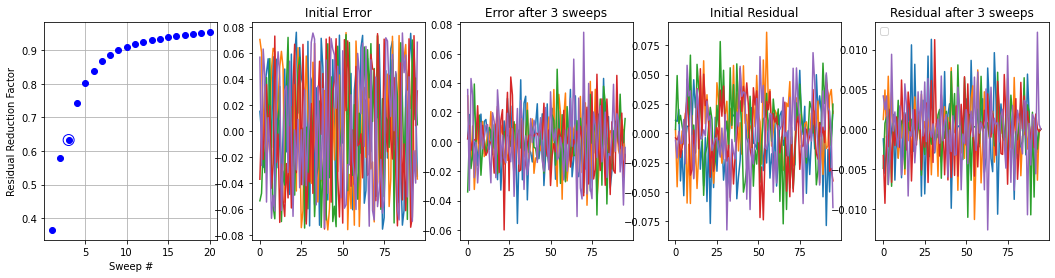

In [31]:
m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, q, aggregate_size, num_components)
m1 = m0.sub_hierarchy(1)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

### Conclusions
* It is important to not exactly solve at the coarse level especially when null/near-null space components are present, in order to avoid inflating them due to round-off errors.
* $Q A P$ is as good as $R A P$ for different seeds.
* A two-level cycle (with many relaxations at the coarse level) does not reduce the RER more than relaxation. That's OK: again, many relaxations at the coarse level will affeect very smooth components and thus their aliasing.
* To see good shrinkage, use a relaxation mini-cycle (only several relaxations at the coarse level). Note that we only need one relaxation at the coarse level to get a good RER reduction (and indeed, Kaczmarz is a good smoother at level 1).

## Equation Interpretability
We (maybe) expect the coarse equations to be $U x_{i-1} + x_i + U^T x_{i+1}$ where $U$ is a rotation whose angle depends on $kh$.

In [32]:
# Normalized level 0 equations.
level.a.todense()[2, :5] / level.a.todense()[2,2]

matrix([[ 0.037, -0.59 ,  1.   , -0.59 ,  0.037]])

In [33]:
ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, q, aggregate_size, num_components)

print("R")
display(pd.DataFrame(r[:2, :4].todense()))
print("Q")
display(pd.DataFrame(q[:2, :4].todense()))
print("P")
display(pd.DataFrame(ml[1]._p[6:10, 2:6].todense()))
print("RAP")
display(pd.DataFrame(r.dot(ml[0].a).dot(ml[1]._p)[4:6, 2:8].todense()))
print("QAP")
qap = q.dot(ml[0].a).dot(ml[1]._p)[4:6, 2:8].todense()
display(pd.DataFrame(qap))

R


,0,1,2,3
0,-0.4692,-0.5568,-0.5386,-0.4240
1,-0.6401,-0.2352,0.2637,0.6822


Q


,0,1,2,3
0,-0.4692,-0.5569,-0.5415,-0.4326
1,-0.6274,-0.2333,0.2574,0.6890


P


,0,1,2,3
0,-0.5814,0.4373,0.0910,0.1273
1,-0.3713,0.4762,-0.1060,-0.1568
2,-0.0946,0.1683,-0.4005,-0.4461
3,0.0791,-0.1326,-0.6108,-0.3936


RAP


,0,1,2,3,4,5
0,0.1540,-0.1910,-0.0735,-0.0247,0.1518,0.1668
1,0.1714,-0.1833,-0.0201,-0.7241,-0.1919,-0.1834


QAP


,0,1,2,3,4,5
0,0.1538,-0.1906,-0.0735,-0.0204,0.1538,0.1685
1,0.1685,-0.1805,-0.0204,-0.7156,-0.1906,-0.1805


In [34]:
d = qap[:, 2:4]
u = qap[:, :2]
l, v = eig(d)
#l = np.diag(np.abs(np.real(lam))**(-0.5))
#v = v.dot(l)
U = v.T.dot(u).dot(v)

In [35]:
# Off-diagonal U in U*x_{i-1} + x_i + U^T*x_{i+1} at level 1. x_i is a 2-species vector.
print("D", v.T.dot(d).dot(v))
print("U", U)

D [[-0.073 -0.   ]
 [-0.    -0.716]]
U [[ 0.154 -0.18 ]
 [ 0.179 -0.181]]


In [36]:
# U = V^{-1}*D*V
D, V = eig(U)
print(V, D)

[[0.708+0.j    0.708-0.j   ]
 [0.659-0.254j 0.659+0.254j]] [-0.013+0.065j -0.013-0.065j]


* The original diagonal block is already nearly diagonal.
* $U$ is nearly but not exactly anti-symmetric, as is the corresponding block before diagonalizing the central block.
What does it mean? Will it become symmetric in the limit of many coarsening levels?
* $U$ has real eigenvalues. In quantum mehcanics it's called "PT-symmetric" (space-time-reversible system). cf. https://math.stackexchange.com/questions/746223/besides-being-symmetric-when-will-a-matrix-have-only-real-eigenvalues, 
https://arxiv.org/pdf/1212.1861.pdf . This happens iff there exists a self-adjoint (symmetric positive definite here) $W$ such that $W U = U^* W$.

In [37]:
# Example of an SPD matrix that commutes with U. Any w in the range where (b - c*w)^2 < (d-a)^2 w works. We take w = b/c, 
# which means W is nothing but a diagonal scaling of U...
#w = U[0, 1] / U[1, 0]
#w12 = (U[0, 1] - U[1, 0] * w) / (U[1, 1] - U[0, 0])
#W = np.array([[1, w12], [w12, w]])
W = np.diag(np.sign(np.real(l))).dot(np.array([[1, 0], [0, np.abs(U[0, 1] / U[1, 0])]]))
#W = np.array([[1, 0], [0, np.abs(U[0, 1] / U[1, 0])]])

In [38]:
print("W", W, "W U", W.dot(U), "U^* T", U.T.dot(W), "diff", W.dot(U) - U.T.dot(W))

W [[-1.     0.   ]
 [ 0.    -1.005]] W U [[-0.154  0.18 ]
 [-0.18   0.182]] U^* T [[-0.154 -0.18 ]
 [ 0.18   0.182]] diff [[ 0.    0.36]
 [-0.36  0.  ]]


In [39]:
# After the full transformation - diagonalizing the central block and symmetrizing U:
print("D")
print(W.dot(v.T).dot(d).dot(v))
print("U") 
print(W.dot(v.T).dot(u).dot(v))

D
[[0.073 0.   ]
 [0.    0.72 ]]
U
[[-0.154  0.18 ]
 [-0.18   0.182]]


So this is rather trivial - one can always make the central block symmetric. If it is positive definite, $U$ can be made anti-symmetric via diagonal scaling of the equations.

### Spectral Comparison

In [40]:
# Minimum eigenvalue of A is machine 0.
lam = np.real(eig(level.a.todense())[0])
lam0 = lam[np.argsort(np.abs(lam))][:30]
print(lam0)
print("min", lam0[0])

[ 0.     0.     0.031  0.031 -0.033 -0.033  0.06   0.06  -0.068 -0.068  0.087  0.087 -0.106 -0.106  0.111  0.111  0.134  0.134 -0.145 -0.145  0.154  0.154  0.172  0.172 -0.187 -0.187  0.188  0.188  0.202  0.202]
min 3.9547534157186197e-16


In [41]:
# Minimum eigenvalue of RAP is small but non-zero.
ac = r.dot(ml[0].a).dot(ml[1]._p)
lam = np.real(eig(ac.todense())[0])
lam1 = lam[np.argsort(np.abs(lam))][:30]
print(lam1)
print("min", lam1[0])

[-0.    -0.     0.031  0.031 -0.034 -0.034  0.061  0.061 -0.07  -0.07   0.087  0.087 -0.108 -0.108  0.112  0.112  0.134  0.134 -0.147 -0.147  0.154  0.154  0.171  0.171  0.186  0.186 -0.189 -0.189  0.199  0.199]
min -8.4882924790997e-05


In [42]:
# Minimum eigenvalue of QAP is the same.
ac = q.dot(ml[0].a).dot(ml[1]._p)
lam = np.real(eig(ac.todense())[0])
lam2 = lam[np.argsort(np.abs(lam))][:30]
print(lam2)
print("min", lam2[0])

[-0.    -0.     0.031  0.031 -0.034 -0.034  0.061  0.061 -0.07  -0.07   0.088  0.088 -0.108 -0.108  0.112  0.112  0.134  0.134 -0.148 -0.148  0.154  0.154  0.172  0.172  0.187  0.187 -0.189 -0.189  0.2    0.2  ]
min -0.0002569310054758409


In [43]:
# High order operator eigenvalue of P^T*A*P i sthe same.
ac = ml[1]._p.T.dot(ml[0].a).dot(ml[1]._p)
lam = np.real(eig(ac.todense())[0])
lam3 = lam[np.argsort(np.abs(lam))][:30]
print(lam3)
print("min", lam2[0])

[-0.001 -0.001  0.031  0.031 -0.034 -0.034  0.06   0.06  -0.07  -0.07   0.087  0.087 -0.108 -0.108  0.112  0.112  0.134  0.134 -0.148 -0.148  0.154  0.154  0.172  0.172  0.188  0.188 -0.19  -0.19   0.202  0.202]
min -0.0002569310054758409


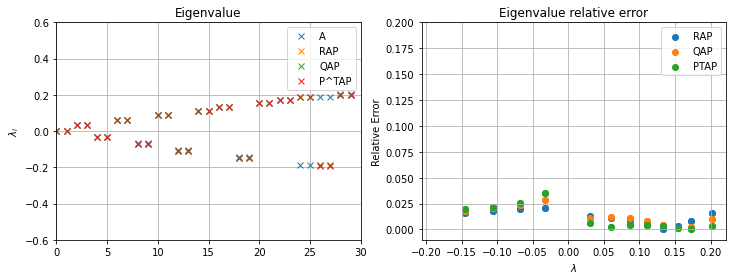

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
ax.plot(lam0, "x", label="A")
ax.plot(lam1, "x", label="RAP")
ax.plot(lam2, "x", label="QAP")
ax.plot(lam3, "x", label="P^TAP")
ax.grid(True);
ax.legend();
ax.set_xlim([0, 30]);
ax.set_ylim([-0.6, 0.6]);
ax.set_title("Eigenvalue");
ax.set_ylabel("$i$")
ax.set_ylabel("$\lambda_i$")

ax = axs[1]
ax.scatter(lam0, np.abs(lam1 - lam0) / np.clip(np.abs(lam0), 1e-6, None), label="RAP")
ax.scatter(lam0, np.abs(lam2 - lam0) / np.clip(np.abs(lam0), 1e-6, None), label="QAP")
ax.scatter(lam0, np.abs(lam3 - lam0) / np.clip(np.abs(lam0), 1e-6, None), label="PTAP")
ax.grid(True);
ax.legend();
ax.set_xlabel("$\lambda$")
ax.set_ylabel("Relative Error")
ax.set_ylim([-0.01, 0.2]);
ax.set_title("Eigenvalue relative error");

Here we can clearly see that $QAP$ is a compromise between sparsity and accuracy: $P^T A P$ approximates many more eigenvalues accurately. It is unexpected that neither $P^T A P$ nor $R A P$ is exactly singular while $Q A P$ is (once again explaining while a direct coarse level solve is especially bad with $Q A P$).

## Auto-setup

In [45]:
# multilevel = hm.setup.auto_setup.setup(level.a, level.location, domain_size, max_levels=2, 
#                                        repetitive=True, symmetrize=True,
#                                       num_bootstrap_steps=1, caliber=4)

In [46]:
ml = hm.setup.hierarchy.multilevel.Multilevel.create(level)

for l in range(3):
    ml1 = helmholtz.analysis.stats.coarsen_qap(ml[-1], nu, 
                           domain_size,
                           aggregate_size, num_components,
                           ideal_tv=ideal_tv,
                           num_examples=num_examples,
                           interpolation_method=interpolation_method,
                           fit_scheme=fit_scheme,
                           weighted=weighted,
                           neighborhood=neighborhood,
                           repetitive=repetitive,
                           m=m,
                           use_q=False)
    mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(ml1[0], ml1[1]._r, nu) for nu in nu_values])
    print(mock_conv)
    two_level_conv = np.array([hm.repetitive.locality.two_level_conv_factor(
        ml1, nu, nu_coarsest=-1, print_frequency=None)[1] for nu in nu_values])
    print(two_level_conv)
    ml.add(ml1[1])

INFO     Generating 4 TVs with 20 sweeps
INFO     RER 0.210
[0.366 0.109 0.091 0.082 0.062 0.048 0.041 0.028 0.029 0.029 0.029]
[0.345 0.13  0.089 0.084 0.065 0.049 0.039 0.033 0.029 0.024 0.022]
INFO     Generating 4 TVs with 20 sweeps
INFO     RER 0.162
[0.523 0.458 0.435 0.41  0.386 0.362 0.34  0.319 0.3   0.282 0.265]
[0.845 0.64  0.438 0.289 0.189 0.123 0.08  0.052 0.034 0.022 0.014]
INFO     Generating 4 TVs with 20 sweeps
INFO     RER 0.203
[0.033 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
WARNING  /Users/olivne/helmholtz/src/helmholtz/solve/run.py:62: RuntimeWarning: invalid value encountered in double_scalars
  rer = r_norm / norm(e)

[0.033 0.001 0.    0.003 0.    0.    0.    0.096 0.    0.082 0.   ]


In [ ]:
# Using GMRES as as a coarse-level solver seems to be a robust choice vs. m (domain size).
m = None
nu_coarsest = -1
hm.repetitive.locality.two_level_conv_factor(
    ml, 8, num_levels=3,
    nu_coarsest=200, print_frequency=1, debug=False, num_sweeps=10);